<a href="https://colab.research.google.com/github/sizhky/AutoTrain/blob/master/nbs/2_segmentation_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Data and Libraries

In [1]:
%%capture
!pip install -U torch-snippets typer imgaug

In [2]:
# Setup Data
# %%capture
%load_ext autoreload
%autoreload 2

from torch_snippets import *

# If running locally from AutoTrain/nbs
if not os.path.exists('/content') and P().resolve().stem != 'AutoTrain':
    %cd ..

if os.path.exists('/content') and not os.path.exists('/content/AutoTrain'):
    !git clone https://github.com/sizhky/AutoTrain

if not P().resolve().stem == 'AutoTrain':
    %cd AutoTrain

!git pull origin segmentation
!git checkout segmentation

if not os.path.exists('balloon.zip'):
    !wget --quiet https://www.dropbox.com/s/tur7gzmuuzb2vzf/balloon.zip -O balloon.zip
if not os.path.exists('balloon/data/'):
    makedir('balloon')
    unzip_file('balloon.zip', 'balloon/data/')

/mnt/d04d289c-d0a7-4fd4-b883-ff227b3a8695/githubs/AutoTrain
From https://github.com/sizhky/AutoTrain
 * branch            segmentation -> FETCH_HEAD
Already up to date.
M	auto_train_segmentation/custom_functions.py
M	auto_train_segmentation/train.py
M	config.ini
Switched to branch 'segmentation'
Your branch is up to date with 'origin/segmentation'.


In [3]:
%%time
try:
    from icevision.all import *
except:
    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
    !bash install_colab.sh

CPU times: user 413 ms, sys: 50.4 ms, total: 464 ms
Wall time: 471 ms


## Verify Config

In [13]:
!cat config.ini

[project]
owner: sizhky
name: baloons
location: ${project.name}
model_directory: ${project.location}/models
type: segmentation

[architecture]
model_type: torchvision.mask_rcnn
backbone: resnet34_fpn
pretrained: True
size: 384
[architecture.extra_args]

[training]
; absolute path, or path relative to AutoTrain folder
dir: balloon/data/balloon
; folder should be exported from label studio, 
; in COCO format for segmentation, i.e., 
; it should have one images dir and one results.json file
images_dir: ${training.dir}/images
annotations_file: ${training.dir}/result.json
train_ratio: 0.8

[training.preprocess]
@augmentations: get_train_transforms
size: ${architecture.size}
presize: 512

[training.scheme]
epochs: 20
lr: 1e-4
freeze_epochs: 1
output_path: ${project.model_directory}/model.pt

[testing]
[testing.preprocess]
@augmentations: get_val_transforms
size: ${architecture.size}
presize: 512


In [29]:
!python auto_train_segmentation/train.py find-best-learning-rate

INFO     - 
CLASSES INFERRED FROM balloon/data/balloon/result.json: <ClassMap: {'background': 0, 'balloon': 1}> | __main__:<module>:34
100%|███████████████████████████████████████| 255/255 [00:00<00:00, 2252.17it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:136
100%|████████████████████████████████████████| 13/13 [00:00<00:00, 10610.23it/s]
INFO     - LR Plot is saved at baloons/find_lr_plot.png | __main__:find_best_learning_rate:80
INFO     - Suggested LRs: 4.365158267319202e-05 and 7.585775847473997e-07 | __main__:find_best_learning_rate:81


In [33]:
!python auto_train_segmentation/train.py train-model --lr 4.365158267319202e-05

INFO     - 
CLASSES INFERRED FROM balloon/data/balloon/result.json: <ClassMap: {'background': 0, 'balloon': 1}> | __main__:<module>:34
100%|███████████████████████████████████████| 255/255 [00:00<00:00, 2244.67it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:136
100%|████████████████████████████████████████| 13/13 [00:00<00:00, 13218.41it/s]
INFO     - Loaded weights from baloons/models/model.pt to given model | __main__:train_model:87
[0, 1.078104853630066, 0.80428147315979, 0.15314963017105154, '00:07']
[0, 1.056432843208313, 0.809590756893158, 0.16396020767439654, '00:08']
[1, 1.0458848476409912, 0.8110312819480896, 0.1521259160799801, '00:08']
[2, 1.047467589378357, 0.8237537741661072, 0.13200266981122477, '00:08']
[3, 1.0257574319839478, 0.817683219909668, 0.13218423967902862, '00:07']
[4, 1.028222680091858, 0.8430755138397217, 0.12064020289547524, '00:08']
[5, 1.0255986452102661, 0.8170281052589417, 0.13825889154935847, '00:07']
[6, 1.0311779975891113, 0.81270

---
## Validate

In [39]:
from torch_snippets import *
from icevision.all import *
from auto_train_object_detection.custom_functions import *
from torch_snippets.registry import registry, Config, AttrDict

config = Config().from_disk('config.ini')
config = AttrDict(registry.resolve(config))

image_size = config.architecture.size
class_map = ClassMap(config.project.classes)

assert config.architecture.model_type.count('.', 1), "Architecture should look like <base>.<model>"
extra_args = config.architecture.extra_args
a, b = config.architecture.model_type.split('.')
model_type = getattr(getattr(models, a), b)
backbone = getattr(model_type.backbones, config.architecture.backbone)(config.architecture.pretrained)
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map), **extra_args)

from torch_snippets import load_torch_model_weights_to, save_torch_model_weights_from, makedir
yolo_path = config.training.scheme.output_path
load_torch_model_weights_to(model, yolo_path, device='cpu')


INFO     - Loaded weights from baloons/models/model.pt to given model | __main__:<module>:21


In [ ]:
folder = 'balloon/data/balloon/validation'
fpaths = []
image_extns = ['png','jpg','jpeg']
for extn in image_extns:
    fpaths += P(folder).Glob(f'*.{extn}')
imgs = [read(f, 1) for f in fpaths][:4]
logger.info(f'Found {len(imgs)} images')

infer_tfms = tfms.A.Adapter([
    *tfms.A.resize_and_pad(size=512),
    tfms.A.Normalize()
])

infer_ds = Dataset.from_images(imgs, infer_tfms, class_map=class_map)
infer_dl = model_type.infer_dl(infer_ds, batch_size=1)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

INFO     - Found 4 images | __main__:<module>:7


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
show_preds(preds=preds, ncols=3)

---

INFO     - CLASSES INFERRED FROM balloon/data/balloon/result.json: <ClassMap: {'background': 0, 'balloon': 1}> | __main__:<module>:34


  0%|          | 0/255 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=3.630780702224001e-05)

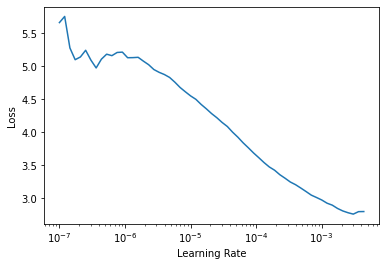

In [4]:
from icevision.all import *
from torch_snippets import Glob, parent, P, sys
sys.path.append(str(P().resolve()))
from auto_train_segmentation.custom_functions import *
from torch_snippets.markup import read_json, write_json
from torch_snippets.registry import Config, registry, AttrDict

config = Config().from_disk('config.ini')
config = AttrDict(registry.resolve(config))

from torch_snippets import *
from icevision.all import *

def incby1(d):
    for k,v in d.items():
        if k in ['id', 'image_id', 'category_id']:
            d[k] = v+1
        if isinstance(v, list):
            [incby1(i) for i in v if isinstance(i, dict)]
        if isinstance(v, dict):
            incby1(v)

x = read_json(config.training.annotations_file)
# ids start from 0, but it's better to number them from 1
incby1(x)
write_json(x, '/tmp/intermediate-file.json')

parser = parsers.COCOMaskParser(
    '/tmp/intermediate-file.json', 
    config.training.images_dir
)

data_splitter = RandomSplitter((config.training.train_ratio, 1 - config.training.train_ratio))
logger.info(f'CLASSES INFERRED FROM {config.training.annotations_file}: {parser.class_map}')
train_records, valid_records = parser.parse(data_splitter)

presize = config.architecture.presize
size = config.architecture.size

train_tfms = config.training.preprocess
valid_tfms = config.testing.preprocess

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

extra_args = config.architecture.extra_args
assert config.architecture.model_type.count('.', 1), "Architecture should look like <base>.<model>"
a, b = config.architecture.model_type.split('.')
model_type = getattr(getattr(models, a), b)
backbone = getattr(model_type.backbones, config.architecture.backbone)(config.architecture.pretrained)
model = model_type.model(
    backbone=backbone(pretrained=True), 
    num_classes=len(parser.class_map),
    **extra_args
)

train_dl = model_type.train_dl(train_ds, batch_size=4, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=4, num_workers=4, shuffle=False)
# model_type.show_batch(first(valid_dl), ncols=4)

metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)



In [26]:
ax = learn.lr_find(show_plot=False)

In [28]:
ax.lr

0.00020892962347716094

In [20]:
??learn.recorder.plot_lr_find

Signature: learn.recorder.plot_lr_find(skip_end=5)
Source:   
@patch
def plot_lr_find(self:Recorder, skip_end=5):
    "Plot the result of an LR Finder test (won't work if you didn't do `learn.lr_find()` before)"
    lrs    = self.lrs    if skip_end==0 else self.lrs   [:-skip_end]
    losses = self.losses if skip_end==0 else self.losses[:-skip_end]
    fig, ax = plt.subplots(1,1)
    ax.plot(lrs, losses)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log')
File:      ~/anaconda3/lib/python3.7/site-packages/fastai/callback/schedule.py
Type:      method


In [14]:
learn.lr_find??

Signature:
learn.lr_find(
    start_lr=1e-07,
    end_lr=10,
    num_it=100,
    stop_div=True,
    show_plot=True,
    suggestions=True,
)
Source:   
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggestions=True):
    "Launch a mock training to find a good learning rate, return lr_min, lr_steep if `suggestions` is True"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if show_plot: self.recorder.plot_lr_find()
    if suggestions:
        lrs,losses = tensor(self.recorder.lrs[num_it//10:-5]),tensor(self.recorder.losses[num_it//10:-5])
        if len(losses) == 0: return
        lr_min = lrs[losses.argmin()].item()
        grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
        lr_steep = lrs[grads.argmin()].item()
        return SuggestedLRs(lr_min/10.,lr_steep)
File:      ~/